In [1]:
from model_utils import *

In [2]:
MODEL_NAME = 'skimai/spanberta-base-cased'
FILE = 'data/augmented_es_data.json'
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 128
LEARN_RATE = 3e-5
EPOCH = 4
MAX_CATE_SIZE = 30000
DATASET_NAME = 'NewCate'
TASK = 'NewsCate'

In [3]:
import datetime
TODAY = datetime.date.today().strftime("%m%d")
RESULT_DIR = 'results/{}-results-{}'.format(TASK,TODAY)
SUB_DIR = '/{}-{}'.format(LEARN_RATE, MAX_SEQ_LENGTH)
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
if not os.path.exists("{}{}".format(RESULT_DIR,SUB_DIR)):
    os.makedirs("{}{}".format(RESULT_DIR,SUB_DIR))
OUTPUT_PATH = RESULT_DIR + SUB_DIR

## Train

init

In [4]:
# load data
labels,contents,lset,ldic = load_data(FILE,MAX_CATE_SIZE,percentage=0.5)

# encode 1 87s
start = time.time()
encodings_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print('encoding time cost :',time.time()-start)

# load dataset
train_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic)
valid_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic, 'val')
test_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic, 'test')
print('data loaded \ntrain:{}\nvalid:{}\ntest:{}'.format(len(train_dataset),
                                                          len(valid_dataset),
                                                          len(test_dataset)))

# dataloader
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False),
    "test": DataLoader(dataset=test_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False)
}

Data loaded:  358316 358316


100%|██████████| 358316/358316 [01:26<00:00, 4164.18it/s]

Tokenizer loaded...
encoding time cost : 91.27066564559937
data loaded 
train:250821
valid:53748
test:53747


## 1.From pre-training

In [5]:
model = RobertaForSequenceClassification(MODEL_NAME,len(ldic))
model.MLP.apply(weight_init)
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()

## 2.Going on

In [6]:
model = RobertaForSequenceClassification(MODEL_NAME,len(lset))
state_dict = torch.load('./results/3.699999999999999e-05-128/5-18-epoch-4.pth')
model.load_state_dict(state_dict)
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARN_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

acclist,losslist = train_classifier(model,EPOCH,LEARN_RATE, MAX_SEQ_LENGTH,
                                    train_val_loaders,criterion,TODAY,
                                    optimizer,scheduler,path=OUTPUT_PATH)

epoch 0


  0%|          | 0/2906 [00:00<?, ?it/s]

Epoch 0 batch 2905, loss: 0.9235 acc: 81.25 8 
validating...
After Epoch 0 , valid acc: 0.8099767835853674, avg loss1.0093486394171705  avg acc0.703799789229181
epoch 1


  0%|          | 0/2906 [00:00<?, ?it/s]

Epoch 1 batch 2905, loss: 0.2039 acc: 93.75 8 
validating...
After Epoch 1 , valid acc: 0.9047123046997553, avg loss0.7128892766423293  avg acc0.78850331211287
epoch 2


  0%|          | 0/2906 [00:00<?, ?it/s]

Epoch 2 batch 2905, loss: 0.3375 acc: 93.75 8  
validating...
After Epoch 2 , valid acc: 0.9358599485474054, avg loss0.5325572092716787  avg acc0.8409773600596467
epoch 3


  0%|          | 0/2906 [00:00<?, ?it/s]

Epoch 3 batch 2905, loss: 0.0433 acc: 100.0 2  
validating...
After Epoch 3 , valid acc: 0.9459371274392923, avg loss0.4223640477465862  avg acc0.8733204200361322
epoch 4


  0%|          | 0/2906 [00:00<?, ?it/s]

Epoch 4 batch 2905, loss: 0.009869 acc: 100.0  
validating...
After Epoch 4 , valid acc: 0.9498274455669198, avg loss0.350517008062138  avg acc0.8944963007570543


## Hyperparameter optimization

In [5]:
init_lr = LEARN_RATE
step = 1e-6
accs = []
losses = []
lrs = []
for i in range(20):
    model = RobertaForSequenceClassification(MODEL_NAME,len(ldic))
    model.apply(weight_init)
    torch.cuda.empty_cache()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=init_lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    if torch.cuda.is_available():
        model = nn.DataParallel(model)
        model.cuda()
    acclist,losslist = train_classifier(model,EPOCH, init_lr, MAX_SEQ_LENGTH,
                                        train_val_loaders,criterion,TODAY,
                                        optimizer,scheduler,path=OUTPUT_PATH)
    accs.append(acclist)
    losses.append(losslist)
    lrs.append(init_lr)
    init_lr+=step
    

epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 1.11 acc: 66.6667   
validating...
After Epoch 0 , valid acc: 0.6931606757460743, avg loss1.4770031960034857  avg acc0.5767152954931972
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 1.001 acc: 75.3623  
validating...
After Epoch 1 , valid acc: 0.7493674183225423, avg loss1.184313897925372  avg acc0.6573895828711919
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.5993 acc: 82.6087 
validating...
After Epoch 2 , valid acc: 0.7927364739153084, avg loss0.9929692909881777  avg acc0.7110338757332643
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.3735 acc: 89.8551 
validating...
After Epoch 3 , valid acc: 0.8091091761553918, avg loss0.8488508318417839  avg acc0.7519965229638051
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 1.184 acc: 63.7681  
validating...
After Epoch 0 , valid acc: 0.6950584207784476, avg loss1.4595540398237656  avg acc0.5826435873262348
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.6725 acc: 81.1594 
validating...
After Epoch 1 , valid acc: 0.7531815137307435, avg loss1.1681594473062729  avg acc0.6620406314699794
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.7151 acc: 72.4638 
validating...
After Epoch 2 , valid acc: 0.7954156433727767, avg loss0.9755729791663942  avg acc0.7160890477114759
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.544 acc: 85.5072  
validating...
After Epoch 3 , valid acc: 0.8229515516856442, avg loss0.8313489448640268  avg acc0.7572531789550059
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 1.175 acc: 69.5652  
validating...
After Epoch 0 , valid acc: 0.690072188732604, avg loss1.4668084829133383  avg acc0.581541149068323
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.7908 acc: 75.3623 
validating...
After Epoch 1 , valid acc: 0.7525117213663765, avg loss1.1687667198935334  avg acc0.6627202392505915
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.5064 acc: 82.6087 
validating...
After Epoch 2 , valid acc: 0.7900386991143856, avg loss0.9741039631216705  avg acc0.7173525807515034
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.4321 acc: 85.5072 
validating...
After Epoch 3 , valid acc: 0.8214445188658183, avg loss0.829164462260978  avg acc0.7586632011840062
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 0.9506 acc: 75.3623 
validating...
After Epoch 0 , valid acc: 0.6930304383418918, avg loss1.4601722144654818  avg acc0.5831810577491866
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.6923 acc: 82.6087 
validating...
After Epoch 1 , valid acc: 0.7576840068467664, avg loss1.159386991146876  avg acc0.6654201269502366
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.4874 acc: 84.058  
validating...
After Epoch 2 , valid acc: 0.794522586886954, avg loss0.9631924760787666  avg acc0.7207506870501825
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.3412 acc: 88.4058 
validating...
After Epoch 3 , valid acc: 0.8222631539778225, avg loss0.8180947611450541  avg acc0.7621820756155723
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 0.9097 acc: 73.913  
validating...
After Epoch 0 , valid acc: 0.6972352459626404, avg loss1.450023693059172  avg acc0.5858522349157054
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.5403 acc: 82.6087 
validating...
After Epoch 1 , valid acc: 0.7527721961747413, avg loss1.1523601774202317  avg acc0.6674153934671694
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.5671 acc: 86.9565 
validating...
After Epoch 2 , valid acc: 0.7953040113120489, avg loss0.956941995503647  avg acc0.7225122929606625
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.5583 acc: 81.1594 
validating...
After Epoch 3 , valid acc: 0.8224492074123688, avg loss0.8114022840099523  avg acc0.764040115026989
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 1.099 acc: 73.913   
validating...
After Epoch 0 , valid acc: 0.6802113567016447, avg loss1.4541288896786924  avg acc0.5865936252218278
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.9381 acc: 79.7101 
validating...
After Epoch 1 , valid acc: 0.7620562625586068, avg loss1.1514041996427944  avg acc0.6695026261183822
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.7352 acc: 75.3623 
validating...
After Epoch 2 , valid acc: 0.7924759991069436, avg loss0.9540922293300126  avg acc0.7248406960157252
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.3809 acc: 88.4058 
validating...
After Epoch 3 , valid acc: 0.8301518196025899, avg loss0.8085708200418371  avg acc0.76626500804126
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 0.9378 acc: 78.2609 
validating...
After Epoch 0 , valid acc: 0.6935141772717124, avg loss1.4402925142220089  avg acc0.5891429125998225
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.6849 acc: 81.1594 
validating...
After Epoch 1 , valid acc: 0.7627818709533378, avg loss1.1382279147451022  avg acc0.6725009127292222
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.5946 acc: 84.058  
validating...
After Epoch 2 , valid acc: 0.7886432983552877, avg loss0.9419902010104891  avg acc0.7277432134538598
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.5864 acc: 82.6087 
validating...
After Epoch 3 , valid acc: 0.8203095929150852, avg loss0.7973811014631421  avg acc0.7692456466282166
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 0.828 acc: 75.3623  
validating...
After Epoch 0 , valid acc: 0.6969933764977302, avg loss1.436873510358285  avg acc0.5907703434634723
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.7956 acc: 79.7101 
validating...
After Epoch 1 , valid acc: 0.7632283991962492, avg loss1.1340531066972381  avg acc0.6745545534790003
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.7115 acc: 81.1594 
validating...
After Epoch 2 , valid acc: 0.80661606013247, avg loss0.9370516235579033  avg acc0.7301477157892143
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.4145 acc: 91.3043 
validating...
After Epoch 3 , valid acc: 0.8254818783954752, avg loss0.7916375355158305  avg acc0.7715882557166888
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 1.344 acc: 62.3188  
validating...
After Epoch 0 , valid acc: 0.7032819825853985, avg loss1.4549775817564556  avg acc0.5847647007172434
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 1.013 acc: 72.4638  
validating...
After Epoch 1 , valid acc: 0.7685309220808216, avg loss1.1429843929501213  avg acc0.6719438012976929
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.5158 acc: 82.6087 
validating...
After Epoch 2 , valid acc: 0.8019089082384461, avg loss0.9417453451855045  avg acc0.7287458291740608
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.2287 acc: 94.2029 
validating...
After Epoch 3 , valid acc: 0.825853985264568, avg loss0.795417601801455  avg acc0.7706142783200237
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 1.388 acc: 56.5217  
validating...
After Epoch 0 , valid acc: 0.6975515368013694, avg loss1.4544573175359745  avg acc0.5858790968833186
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.7487 acc: 79.7101 
validating...
After Epoch 1 , valid acc: 0.7600096747785964, avg loss1.1371414254970698  avg acc0.674006251617495
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.4382 acc: 84.058  
validating...
After Epoch 2 , valid acc: 0.8058718463942844, avg loss0.9336777468268969  avg acc0.7316459011140689
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.3171 acc: 86.9565 
validating...
After Epoch 3 , valid acc: 0.8311751134925951, avg loss0.7864530328699216  avg acc0.7737775782867495
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 0.9319 acc: 71.0145 
validating...
After Epoch 0 , valid acc: 0.706203021507777, avg loss1.4335488898717628  avg acc0.5927531032793553
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.8464 acc: 81.1594 
validating...
After Epoch 1 , valid acc: 0.7609027312644191, avg loss1.1254837506127602  avg acc0.6779950227373559
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.3877 acc: 89.8551 
validating...
After Epoch 2 , valid acc: 0.8072486418099278, avg loss0.925769964463654  avg acc0.7343880169821551
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.2971 acc: 92.7536 
validating...
After Epoch 3 , valid acc: 0.8323472501302374, avg loss0.780143648216843  avg acc0.7759073279447649
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 0.8588 acc: 72.4638 
validating...
After Epoch 0 , valid acc: 0.7027796383121232, avg loss1.4429329738325003  avg acc0.5907714988169182
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.9537 acc: 72.4638 
validating...
After Epoch 1 , valid acc: 0.7658145419364442, avg loss1.1279634004572825  avg acc0.6779586002199793
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.6655 acc: 76.8116 
validating...
After Epoch 2 , valid acc: 0.8020391456426286, avg loss0.9239522271567867  avg acc0.7354802111061817
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.3783 acc: 86.9565 
validating...
After Epoch 3 , valid acc: 0.8259656173252958, avg loss0.7770113066418515  avg acc0.7773996835486912
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 1.032 acc: 71.0145  
validating...
After Epoch 0 , valid acc: 0.7061286001339585, avg loss1.4295361462600378  avg acc0.5952841938405797
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.8951 acc: 76.8116 
validating...
After Epoch 1 , valid acc: 0.7636377167522512, avg loss1.1183716521503366  avg acc0.6811029523901951
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.4167 acc: 88.4058 
validating...
After Epoch 2 , valid acc: 0.8105231822579445, avg loss0.9164258061318982  avg acc0.7382246184252687
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.3033 acc: 92.7536 
validating...
After Epoch 3 , valid acc: 0.8319937486045993, avg loss0.7706586800553665  avg acc0.7800044856597531
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 0.9971 acc: 76.8116 
validating...
After Epoch 0 , valid acc: 0.6985376200044653, avg loss1.433419174229612  avg acc0.5939944150214433
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.9896 acc: 72.4638 
validating...
After Epoch 1 , valid acc: 0.7624283694276996, avg loss1.1164717636242205  avg acc0.6814374849804052
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.5993 acc: 84.058  
validating...
After Epoch 2 , valid acc: 0.8066904815062886, avg loss0.9122244875624674  avg acc0.7393357603458051
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.4358 acc: 91.3043 
validating...
After Epoch 3 , valid acc: 0.8314727989878693, avg loss0.76516464107993  avg acc0.7813342397081114
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 0.9652 acc: 69.5652 
validating...
After Epoch 0 , valid acc: 0.7131242092729032, avg loss1.4472568742474732  avg acc0.590118955190772
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.6235 acc: 79.7101 
validating...
After Epoch 1 , valid acc: 0.7564932648656694, avg loss1.123776188553596  avg acc0.6800623255416297
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.6355 acc: 86.9565 
validating...
After Epoch 2 , valid acc: 0.8083649624172062, avg loss0.9167212708922876  avg acc0.7388171992075816
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.2768 acc: 92.7536  
validating...
After Epoch 3 , valid acc: 0.8329984371511499, avg loss0.7691598731568273  avg acc0.7808893708638347
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 1.206 acc: 68.1159  
validating...
After Epoch 0 , valid acc: 0.7035610627372181, avg loss1.4608566350778756  avg acc0.5882062675613724
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.5991 acc: 82.6087 
validating...
After Epoch 1 , valid acc: 0.7636935327826152, avg loss1.1278243957049385  avg acc0.680295215912452
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.3616 acc: 89.8551 
validating...
After Epoch 2 , valid acc: 0.8068951402842897, avg loss0.9169791158415428  avg acc0.7395779416839201
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.1863 acc: 95.6522 
validating...
After Epoch 3 , valid acc: 0.8357520279824365, avg loss0.76737214079963  avg acc0.7821033729388495
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 0.863 acc: 75.3623  
validating...
After Epoch 0 , valid acc: 0.7134405001116321, avg loss1.4331552872548299  avg acc0.595868398310411
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.6292 acc: 78.2609 
validating...
After Epoch 1 , valid acc: 0.7663727022400834, avg loss1.115609673349833  avg acc0.6832621924449127
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.5476 acc: 85.5072 
validating...
After Epoch 2 , valid acc: 0.8105045769144898, avg loss0.9091924033932337  avg acc0.7417651027802425
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.2744 acc: 94.2029 
validating...
After Epoch 3 , valid acc: 0.8316030363920518, avg loss0.7623651530213502  avg acc0.7835575441113946
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 0.9998 acc: 68.1159 
validating...
After Epoch 0 , valid acc: 0.7034866413633996, avg loss1.4520667893241863  avg acc0.5906576387348418
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.9272 acc: 76.8116 
validating...
After Epoch 1 , valid acc: 0.7678983404033638, avg loss1.1236979918820518  avg acc0.6819864222863059
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.5261 acc: 86.9565 
validating...
After Epoch 2 , valid acc: 0.8114348440872219, avg loss0.9135460761812877  avg acc0.7414312441462092
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.355 acc: 94.2029   
validating...
After Epoch 3 , valid acc: 0.8316030363920518, avg loss0.7638765419386707  avg acc0.7841342387838288
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 1.45 acc: 62.3188   
validating...
After Epoch 0 , valid acc: 0.6995981245813798, avg loss1.4324845432931064  avg acc0.5953633933192842
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.5899 acc: 81.1594 
validating...
After Epoch 1 , valid acc: 0.7721589640544765, avg loss1.1089505755627642  avg acc0.6855681046195652
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.4936 acc: 86.9565 
validating...
After Epoch 2 , valid acc: 0.8117325295824961, avg loss0.9024074929354547  avg acc0.7444501441881101
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.152 acc: 94.2029  
validating...
After Epoch 3 , valid acc: 0.8273052020540299, avg loss0.756491724039637  avg acc0.7861453047591319
epoch 0


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 0 batch 1959, loss: 0.8771 acc: 72.4638 
validating...
After Epoch 0 , valid acc: 0.7050308848701347, avg loss1.4622899271091636  avg acc0.5876305549393671
epoch 1


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 1 batch 1959, loss: 0.7434 acc: 78.2609 
validating...
After Epoch 1 , valid acc: 0.7807360273870656, avg loss1.126017869583198  avg acc0.6814870207593908
epoch 2


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 2 batch 1959, loss: 0.2579 acc: 89.8551 
validating...
After Epoch 2 , valid acc: 0.8095557043983032, avg loss0.9129397235760073  avg acc0.7419336495920833
epoch 3


  0%|          | 0/1960 [00:00<?, ?it/s]

Epoch 3 batch 1959, loss: 0.4883 acc: 88.4058 
validating...
After Epoch 3 , valid acc: 0.8317332737962343, avg loss0.7622200249637268  avg acc0.7848255156342429


In [6]:
import matplotlib.pyplot as plt

## Accuracy Chart

In [7]:
acc_avg = []
step = 100
for j in range(len(accs)):
    cur = []
    sum = 0
    for idx in range(len(accs[j])):
        sum += accs[j][idx]
        if not (idx + 1) % step:
            cur.append(sum % step)
            sum = 0
    acc_avg.append(cur)
        

In [8]:
acc_avg[0]

[19.7734375,
 39.46875,
 46.8046875,
 51.9140625,
 55.09375,
 55.5,
 58.4140625,
 58.671875,
 60.6875,
 60.65625,
 62.4453125,
 63.4375,
 64.328125,
 64.0703125,
 65.4921875,
 64.9453125,
 65.28125,
 66.25,
 66.7109375,
 69.01822916666666,
 72.1484375,
 72.078125,
 71.875,
 71.921875,
 72.3828125,
 72.4609375,
 73.6484375,
 73.53125,
 73.828125,
 74.1171875,
 74.53125,
 74.2265625,
 74.6640625,
 74.625,
 74.9921875,
 74.859375,
 75.4609375,
 75.921875,
 75.4140625,
 80.4958106884058,
 80.625,
 81.4921875,
 81.4140625,
 80.875,
 81.3671875,
 81.328125,
 81.5,
 82.046875,
 81.8046875,
 81.78125,
 82.0546875,
 82.6171875,
 81.921875,
 82.2265625,
 82.0625,
 82.3125,
 82.6953125,
 82.6796875,
 83.49014945652173,
 87.8515625,
 87.359375,
 87.65625,
 87.4765625,
 87.7890625,
 87.46875,
 87.8125,
 87.4140625,
 86.625,
 86.640625,
 87.1953125,
 87.59375,
 87.421875,
 87.7734375,
 87.71875,
 87.3515625,
 87.5625,
 87.578125,
 87.8515625]

<function matplotlib.pyplot.show(close=None, block=None)>

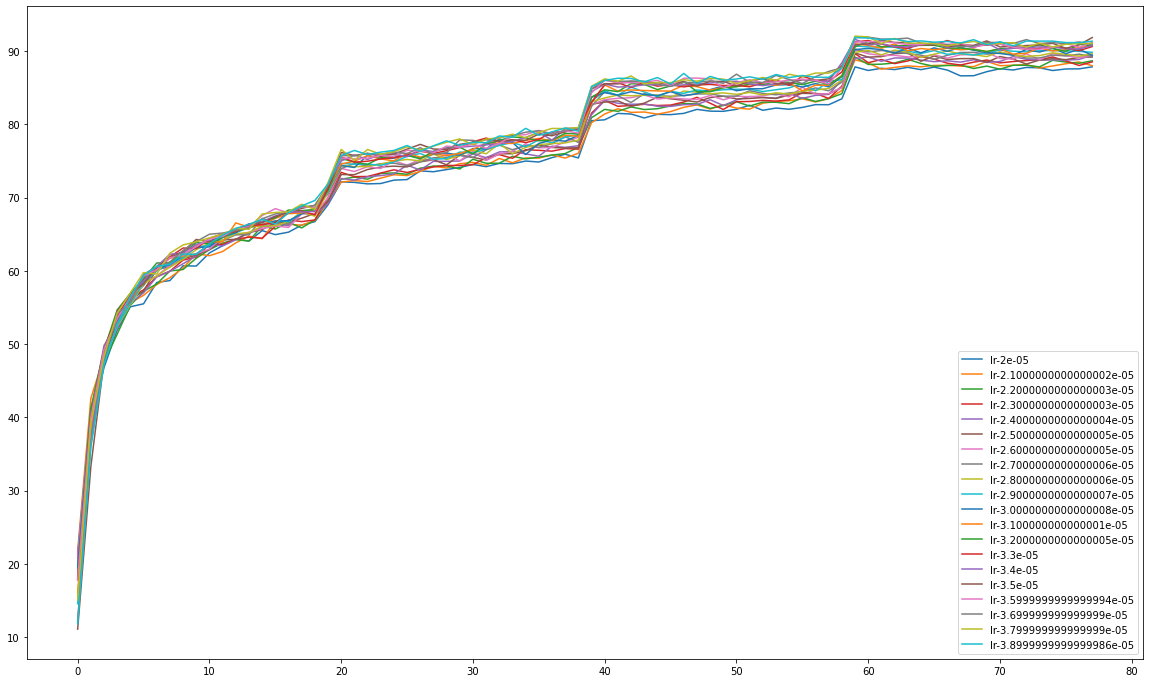

In [9]:
plt.figure(figsize=(20,12))
labels = []
for lr,acc in zip(lrs,acc_avg):
    plt.plot(acc,label='lr-{}'.format(lr))
    labels.append('lr-{}'.format(lr))
plt.legend()
plt.show

In [13]:
for lr,acc in zip(lrs,acc_avg):
    print('{} : [{}]'.format(lr,acc[-5:]))

2e-05 : [[87.71875, 87.3515625, 87.5625, 87.578125, 87.8515625]]
2.1000000000000002e-05 : [[87.6875, 87.9765625, 88.28125, 88.5234375, 88.0078125]]
2.2000000000000003e-05 : [[87.84375, 88.75, 88.5078125, 88.3359375, 88.6796875]]
2.3000000000000003e-05 : [[88.8203125, 89.203125, 88.65625, 88.0390625, 88.53125]]
2.4000000000000004e-05 : [[88.765625, 88.796875, 88.765625, 88.8671875, 89.453125]]
2.5000000000000005e-05 : [[88.78125, 88.96875, 88.8359375, 89.1484375, 89.1875]]
2.6000000000000005e-05 : [[88.8046875, 89.671875, 89.3671875, 89.109375, 89.3203125]]
2.7000000000000006e-05 : [[89.0703125, 89.453125, 89.3515625, 89.578125, 89.28125]]
2.8000000000000006e-05 : [[89.390625, 89.765625, 89.5703125, 89.3125, 89.625]]
2.9000000000000007e-05 : [[90.046875, 90.0859375, 90.046875, 89.96875, 89.8359375]]
3.0000000000000008e-05 : [[89.875, 90.3984375, 89.65625, 90.265625, 89.421875]]
3.100000000000001e-05 : [[90.453125, 90.015625, 90.203125, 90.5, 90.6953125]]
3.2000000000000005e-05 : [[90.87

## Loss Chart

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,12))
labels = []
for lr,loss in zip(lrs,losses):
    plt.plot(accs,label='lr-{}'.format(lr))
    labels.append('lr-{}'.format(lr))
plt.legend(loc='best')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

## Check Acc and Loss

In [10]:
batch_step = 50
new_acc = acclist[0::batch_step]
new_loss = losslist[0::batch_step]

In [11]:
import matplotlib.pyplot as plt

In [12]:
x_label = [i*batch_step for i in range(len(new_acc))]
new_acc = [np.mean(np.array(acclist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_acc))]
loss_acc = [np.mean(np.array(losslist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_loss))]

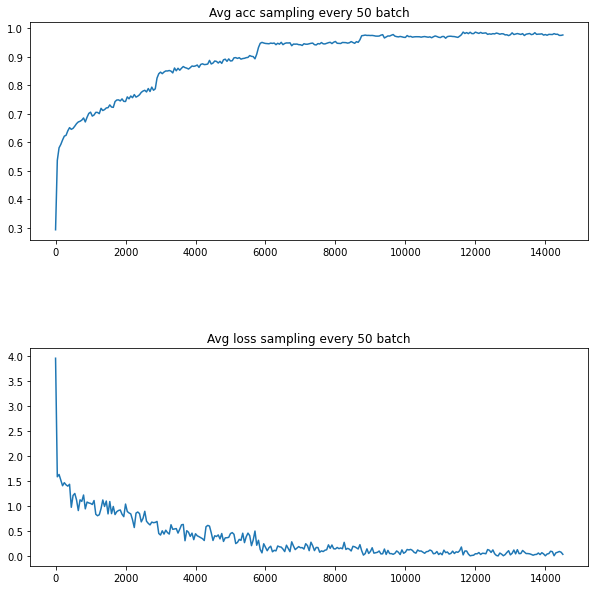

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1,)
ax1.plot(x_label,new_acc)
ax1.set_title('Avg acc sampling every {} batch'.format(batch_step))
ax2 = plt.subplot(2,1,2,sharex=ax1)
ax2.plot(x_label,new_loss)
ax2.set_title('Avg loss sampling every {} batch'.format(batch_step))
plt.subplots_adjust(wspace =0, hspace =0.5)
plt.show()
plt.savefig('./img/{}-{}-acc-loss.jpg'.format(LEARN_RATE,MAX_SEQ_LENGTH))

## Visualization

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
iterator = train_val_loaders
true_labels = []
pred_outputs = []

model.eval()
tkz = AutoTokenizer.from_pretrained(MODEL_NAME)
with torch.no_grad():
    for ba,data in enumerate(notetqdm(iterator['test'])):
        
        features = data['input_ids'].cuda()
        att_mask = data['attention_mask'].to('cuda')
        targets = data['targets']
        targets.numpy()
        true_labels += targets.tolist()
        outputs = model(features,att_mask)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.argmax(outputs,axis=1)
        '''
        # print screen 
        for i in range(len(data)):
            print(data['origin_contents'][i])
            print('pred: ',lset[outputs[i]])
            print('true: ',lset[targets[i]])
            print('--------------')
        
        '''
        
        pred_outputs += outputs.tolist()
    print(len(true_labels))
    print(true_labels[:15])
    print(len(pred_outputs))
    print(pred_outputs[:15])

  0%|          | 0/623 [00:00<?, ?it/s]

79683
[7, 21, 22, 8, 12, 12, 14, 2, 0, 3, 12, 15, 13, 4, 3]
79683
[7, 21, 22, 8, 12, 12, 14, 2, 0, 12, 12, 15, 13, 4, 3]


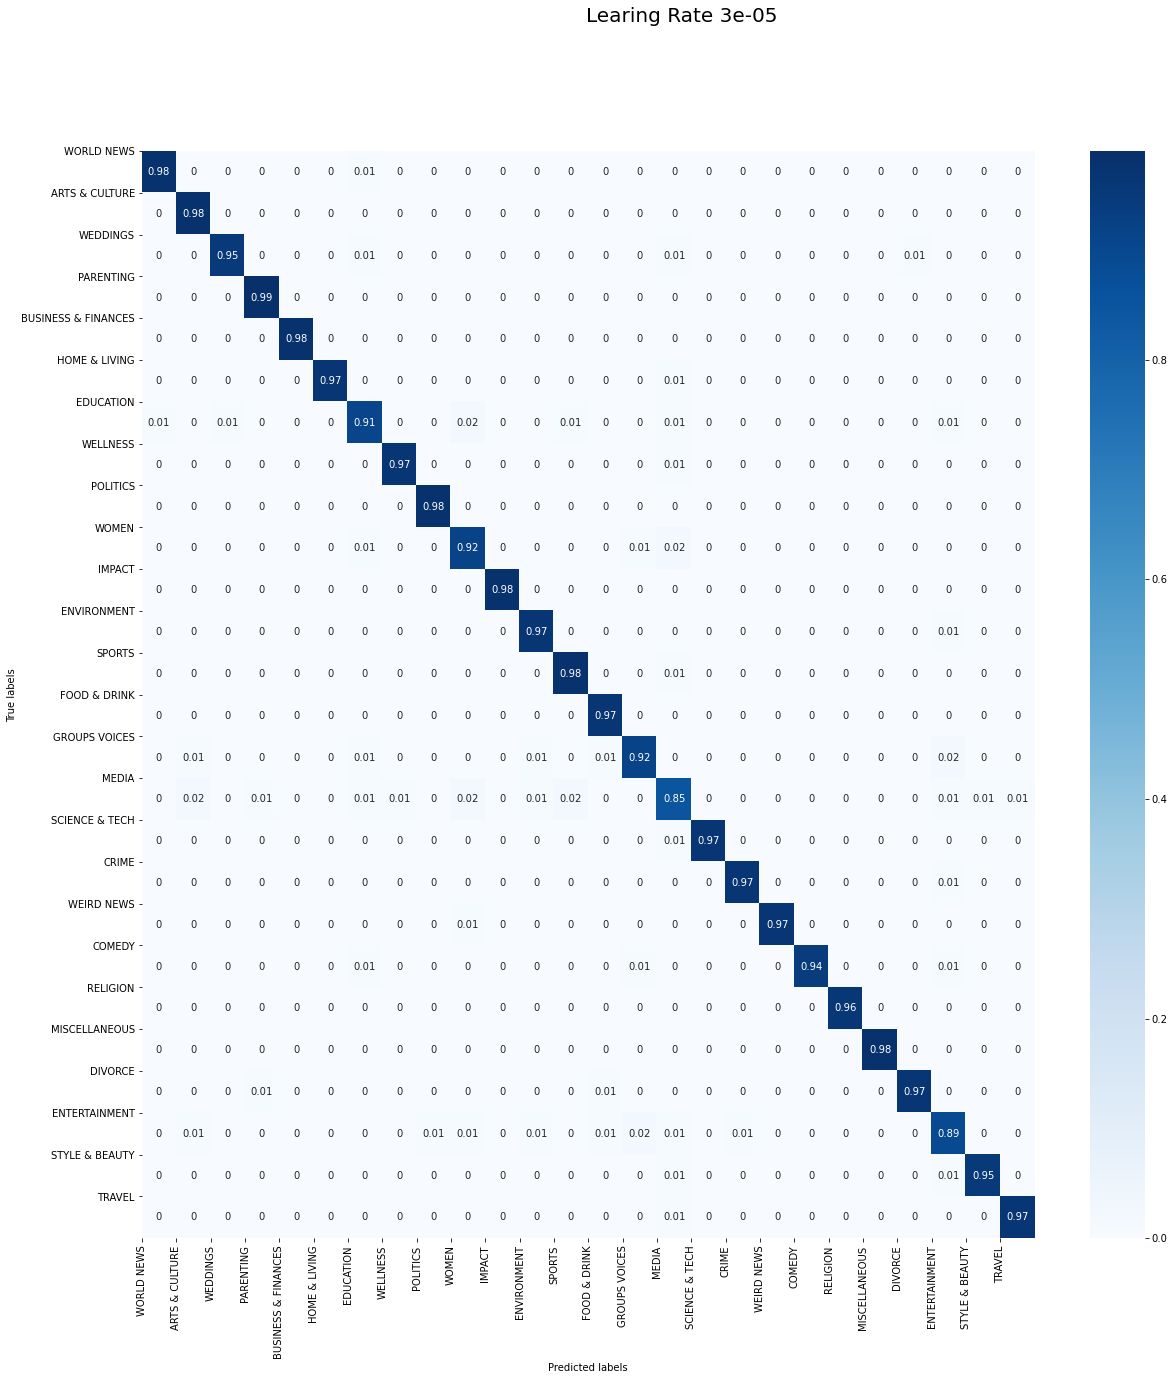

NameError: name 'init_lr' is not defined

In [17]:
lset = list(lset)
true_cate = [lset[i] for i in true_labels]
pred_cate = [lset[j] for j in pred_outputs]
# print(true_cate[:20])
# print(pred_cate[:20])
con_mat = confusion_matrix(true_cate,pred_cate)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # nomalization
con_mat_norm = np.around(con_mat_norm, decimals=2)

# === plot ===
fig = plt.figure(figsize=(20, 20))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
catee = list(range(0,len(lset),1))
fig.suptitle('Learing Rate '+str(LEARN_RATE),fontsize=20)
plt.xlabel('Predicted labels')
plt.xticks(catee,lset)
plt.xticks(rotation=90)

plt.ylabel('True labels')
plt.yticks(catee,lset)
plt.yticks(rotation=360)
plt.show()
plt.savefig('./img/{}-{}-matrix.jpg'.format(init_lr,MAX_SEQ_LENGTH))

## Transformers Trainer

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,
    label_names=['label']
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset
)

In [ ]:
a = torch.Tensor([[0,0,1],
                  [1,0,0]])
print(a.shape)
b = torch.Tensor([2,0]).long()
print(b.shape)
print(criterion(a,b))

In [ ]:
for data in train_val_loaders['valid']:
    print('label:',data['targets'].tolist())

In [15]:
torch.save(model.module.state_dict(),'./results/12-12module.pth')

In [17]:
state_dict

OrderedDict([('module.bert.embeddings.position_ids',
              tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
                        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
                        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
                        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
                        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
                        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
                        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
                        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
                       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
                       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
                 

## Check

In [5]:
for i in range(10):
    print('----------------')
    print(labels[i])
    print(contents[i])

----------------
WORLD NEWS
El nuevo Director General de la OMS debe dar prioridad a los trabajadores sanitarios comunitariosPor Carl Manlan En 1978, se firmó la Declaración de Alma-Ata con el ambicioso objetivo de lograr "La salud para todos en el año 2000"
----------------
MEDIA
Donald Trump ha traído la lucha por la libertad de prensa"Como profesión, luchemos por lo que es correcto", dijo Christiane Amanpour de CNN. "Luchemos por nuestros valores".
----------------
GROUPS VOICES
LeBron James tiene la mejor respuesta al anuncio racista en línea de H&M"¡Nos malinterpretamos a todos! ¡Y no vamos a hacerlo! ¡Derecha!"
----------------
SCIENCE & TECH
Sí, puedes alquilar tu bastón ocular por dineroEn noviembre de 1954, Sammy Davis Jr., de 29 años, estaba conduciendo a Hollywood cuando un accidente de coche dejó su ojo roto más allá de las reparaciones
----------------
ENVIRONMENT
Corte: La ley ambiental clave no se aplica a parte de Enbridge Keystone XL "Clone"Un tribunal de distrito de E

In [16]:
for i in range(1,10,1):
    data = train_dataset[i]
    print(data['origin_contents'])
    print(lset[data['targets'].numpy().tolist()])

Donald Trump ha traído la lucha por la libertad de prensa"Como profesión, luchemos por lo que es correcto", dijo Christiane Amanpour de CNN. "Luchemos por nuestros valores".
MEDIA
LeBron James tiene la mejor respuesta al anuncio racista en línea de H&M"¡Nos malinterpretamos a todos! ¡Y no vamos a hacerlo! ¡Derecha!"
GROUPS VOICES
Sí, puedes alquilar tu bastón ocular por dineroEn noviembre de 1954, Sammy Davis Jr., de 29 años, estaba conduciendo a Hollywood cuando un accidente de coche dejó su ojo roto más allá de las reparaciones
SCIENCE & TECH
Corte: La ley ambiental clave no se aplica a parte de Enbridge Keystone XL "Clone"Un tribunal de distrito de EE.UU. para el Distrito de Columbia ha dictaminado que el Flanagan South Pipeline de 600 millas de largo de Enbridge, un "clone" de Keystone XL, está autorizado legalmente para iniciar la apertura de negocios en octubre.
ENVIRONMENT
Formas creativas de ahorrar en una boda: Aprender chalecoCuando les mostramos cómo Abigail Dalton planeó su

In [18]:
for i,data in enumerate(train_val_loaders['valid']):
    print(data['origin_contents'][0])
    label = lset[data['targets'][0].numpy().tolist()]
    print(label)
    print('----------------')

La conversación imposible: hablar con los niños sobre la islamofobiaIntenté empezar una conversación con él, pero rápidamente me di cuenta de que no iba a ir a ninguna parte.
PARENTING
----------------
Una cosa más que no comeré (y por qué)Bueno, está casi extinguido gracias al insaciable apetito humano por sushi. ¿Miedo a los tiburones? No hay problema, hemos matado a casi todos ellos.
ENVIRONMENT
----------------
Hablando con los niños para que escuchenNos hemos convertido en esos padres que ya están molestos antes de que suceda algo molesto. Que usan el tiempo como muletas, entregándolos de la mañana a la noche. Estamos dejando que el poder lucha con un niño pequeño quite nuestro poder como padres.
PARENTING
----------------
El reportero de los '60 minutos' revela la razón refrigerante de Trump para aplastar a la prensaLesley Stahl dijo que Trump admitió que ataca a periodistas por lo que "Nadie los creerá".
MEDIA
----------------
El sexismo de los padres puede curvar las ambiciones

Un número impactante de padres mantienen las opioides sobrantes de sus hijos"Esta es una oportunidad perdida para prevenir el uso indebido de medicamentos recetados entre los niños".
WELLNESS
----------------
Recordando la masacre en la rodilla heridaCincuenta y un años antes de que la fuerza de ataque japonesa lanzara sus bombas mortales en Pearl Harbor, ocurrió otro "Día de la Infamia" que vivirá para siempre en la mente del pueblo Lakota (Sioux).
MEDIA
----------------
Servidor embarazada recibe una propina de $900 justo a tiempo para la Navidad"Siempre escuchas acerca de estas [cosas] sucediendo, pero nunca esperas ser el receptor de ello."
MISCELLANEOUS
----------------
Discursos de Oscar: ¿Qué ganadores del Oscar agradecieron a sus cónyuges en el escenario?Ganar un Oscar no es una pequeña hazaña, y a menudo puede dejar estrellas perfectamente aturdidas y sin palabras en el escenario.
WEDDINGS
----------------
Un policía se enfrenta a cargos de violación en serie, pero sus 13 acus

Jimmy Kimmel desgarra a Trump por hacer "peor que nada" para detener la violencia armada"Si no estás de acuerdo que tenemos que hacer algo al respecto, obviamente estás mentalmente enfermo".
COMEDY
----------------
Mejores citas de estilo: Gwen Stefani, Lauren Hutton, Lady Gaga y más sobre el maquillajeMuchas estrellas recogen consejos de belleza mientras están en el set de una película, en una sesión de fotos o mientras viajan, por lo que no es sorpresa que estén
STYLE & BEAUTY
----------------
Nueva lista de chequeo de vuelta a la escuela Artículo en California: Inscribirse en la cobertura de saludAquí en California, es nuestro objetivo inscribir aún más familias mientras miramos hacia adelante para el nuevo período de inscripción abierto a partir del 15 de noviembre de 2014.
IMPACT
----------------
El profesor renuncia después de enviar una carta anti-gay sorprendentemente a un periódico estudiantilMichael Stack citó un pasaje bíblico que afirmaba que los gays "recibían morir".
GROU